In [148]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})  # Change 14 to your desired font size

# Also put tex font

plt.rcParams.update({'text.usetex': True, "font.family": "sans-serif",})

In [149]:
def count_subarrays_greater_than_threshold(arr, threshold=0.9):
    result = []
    current_length = 0
    
    for num in arr:
        if num > threshold:
            current_length += 1
        else:
            if current_length > 0:
                result.append(current_length)
                current_length = 0
    
    # Don't forget to check if we have a subarray at the end
    if current_length > 0:
        result.append(current_length)
    
    return result

In [160]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import sys

def overlap_count(str1, str2):
    for i in range(min(len(str1), len(str2)), 0, -1):
        if str1[-i:] == str2[:i]:
            return i
    return 0

# Initialize an empty list to store data from all files
all_data = []

json_file_path = 'jsons/*'  # Replace with actual path

names_dataset = {
    'crispr': 'Genetics',
    'cyber': 'Cryptography',
    'drugs': 'Drugs',
    'nuclear': 'Nuclear physics'
}

n_windows_per_dataset = defaultdict(list)


# Function to load JSON files and extract data
for file in glob.glob(json_file_path):
    prev_text = ""
    cur_arr = []
    # Extract metadata from filename
    filename_parts = file.split('_')
    dataset = filename_parts[2]  # Assuming dataset is consistently at index 2
    deduped = 'deduped' in file
    
    temperature = 0.7
    if 'T0' in file:
        temperature = int(file.split('T0')[1][0]) / 10
    
    # Load the JSON file
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Extract data from each file
    for el in data:
        for item in el['low_perplexity_windows']:
            
            # Create a dictionary for each data point
            data_point = {
                'file': file,
                'dataset': dataset,
                'deduped': deduped,
                'infinigram_count': item.get('infinigram_count', 0),
                'perplexity': item['window_avg_perplexity'],
                'text': item['window_text'],
                'temperature': temperature,
                'in_prompt': item.get('in_prompt', True)
            }
                
            all_data.append(data_point)


        if temperature == 0.7 and not deduped:
                
            with open('../' + el['file'], 'r', encoding='utf-8') as f:
                content = f.readlines()
                values_prob = "\n".join(content).split('Probability: ')
                values_prob = [float(x.split(')')[0]) for x in values_prob[1:]]
                n_windows_per_dataset[names_dataset[dataset]].extend(count_subarrays_greater_than_threshold(values_prob, 0.9))
                    
    print(f"Processed {len([item for el in data for item in el['low_perplexity_windows']])} items from {file}")

# Create a pandas DataFrame from the collected data
df = pd.DataFrame(all_data)

# Map name to dict
df['dataset'] = df['dataset'].map(names_dataset)

df['infinigram_count_adj'] = df['infinigram_count'].copy()
df.loc[df['infinigram_count_adj'] == 0, 'infinigram_count_adj'] = 0.3

# Define regions based on the conditions
def categorize(row):
    if row['infinigram_count_adj'] > 50:
        return "Frequently encountered text"
    elif 5 <= row['infinigram_count_adj'] <= 50:
        return "Segmental replication"
    elif 0.55 <= row['infinigram_count_adj'] <= 5:
        return "Memorization"
    elif row['infinigram_count_adj'] <= 0.55:
        return "Synthetic coherence"
    else:
        return "Other"

# Apply the function to categorize each row
df['category'] = df.apply(categorize, axis=1)
df_deduped = df[(df['dataset'] == 'Genetics') & (df['temperature'] == 0.7)]

df_temperature = df[df['dataset'] == 'Genetics']

df_test = df[df['file'] == 'jsons/perplexity_results_drugs_T1_1_with_counts.json']

df = df[(df['deduped'] == False) & (df['temperature'] == 0.7)]

# Display information about the combined dataset
print("\nCombined Dataset Summary:")
print(f"Total entries: {len(df)}")
print(f"Unique datasets: {df['dataset'].unique()}")
print(f"Sample of the data:")
df

Processed 1519 items from jsons/perplexity_results_crispr_T04_with_counts.json
Processed 1785 items from jsons/perplexity_results_drugs_nd_with_counts.json
Processed 1365 items from jsons/perplexity_results_crispr_2_with_counts.json
Processed 3795 items from jsons/perplexity_results_crispr_T03_2_with_counts.json
Processed 2260 items from jsons/perplexity_results_crispr_T03_with_counts.json
Processed 1749 items from jsons/perplexity_results_crispr_T06_2_with_counts.json
Processed 1509 items from jsons/perplexity_results_cyber_nd_with_counts.json
Processed 545 items from jsons/perplexity_results_crispr_T06_with_counts.json
Processed 4806 items from jsons/perplexity_results_crispr_T02_2_with_counts.json
Processed 158 items from jsons/perplexity_results_cyber_2_with_counts.json
Processed 3660 items from jsons/perplexity_results_crispr_T02_with_counts.json
Processed 3270 items from jsons/perplexity_results_crispr_T04_2_with_counts.json
Processed 1997 items from jsons/perplexity_results_cris

/tmp/ipykernel_11598/79587417.py:84: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




Combined Dataset Summary:
Total entries: 6621
Unique datasets: ['Drugs' 'Genetics' 'Cryptography' 'Nuclear physics']
Sample of the data:


,file,dataset,deduped,infinigram_count,perplexity,text,temperature,in_prompt,infinigram_count_adj,category
1519,jsons/perplexity_results_drugs_nd_with_counts....,Drugs,False,0,7.870192,esculus hippocastanum,0.7,True,0.3,Synthetic coherence
1520,jsons/perplexity_results_drugs_nd_with_counts....,Drugs,False,0,7.136455,culus hippocastanum.,0.7,True,0.3,Synthetic coherence
1521,jsons/perplexity_results_drugs_nd_with_counts....,Drugs,False,2,7.475808,hippocastanum. It,0.7,True,2.0,Memorization
1522,jsons/perplexity_results_drugs_nd_with_counts....,Drugs,False,0,9.096888,ocastanum. It is,0.7,True,0.3,Synthetic coherence
1523,jsons/perplexity_results_drugs_nd_with_counts....,Drugs,False,47,6.930629,and has been found to inhibit the,0.7,True,47.0,Segmental replication
...,...,...,...,...,...,...,...,...,...,...
30217,jsons/perplexity_results_crispr_with_counts.json,Genetics,False,0,10.870570,acer adjacent motif (PAM),0.7,False,0.3,Synthetic coherence
30218,jsons/perplexity_results_crispr_with_counts.json,Genetics,False,723,11.250628,adjacent motif (PAM) sequence,0.7,True,723.0,Frequently encountered text
30219,jsons/perplexity_results_crispr_with_counts.json,Genetics,False,8,7.583385,"gene with a selectable marker,",0.7,True,8.0,Segmental replication
30220,jsons/perplexity_results_crispr_with_counts.json,Genetics,False,43433,4.063880,Caenorhabditis elegans,0.7,True,43433.0,Frequently encountered text


/tmp/ipykernel_11598/1079251128.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




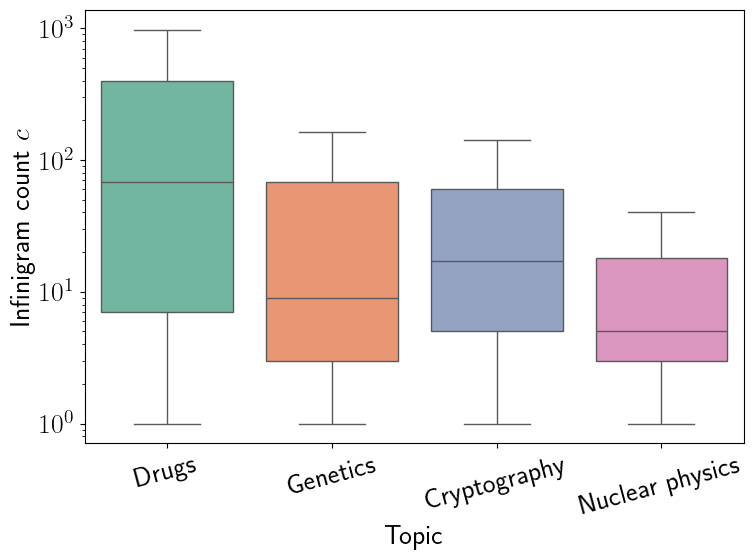

In [172]:
import seaborn as sns

# Create a figure with boxplots for each dataset and deduped combination
plt.figure(figsize=(8, 6))

# Create a boxplot for 'infinigram_count' grouped by 'dataset' and 'deduped'
sns.boxplot(data=df[df['infinigram_count'] > 0], x='dataset', y='infinigram_count', palette='Set2', showfliers=False)

# Add labels and title
plt.xlabel('Topic')
plt.ylabel('Infinigram count $c$')

plt.yscale('log')

# Rotate x-axis labels for better readability
plt.xticks(rotation=15)

# Show the plot
plt.tight_layout()

plt.savefig('boxplot_datasets.png', dpi=300)

plt.show()


In [164]:
comparison_df_melted.groupby('Dataset').agg(['mean', 'std'])



# Generate a LaTeX table from the grouped statistics
latex_table = comparison_df_melted.groupby('Dataset').agg(['mean', 'std']).reset_index().to_latex(
    index=False, 
    float_format="%.2f", 
    caption="Mean and Standard Deviation of Number of Windows per Dataset", 
    label="tab:dataset_stats"
)

# Print the LaTeX table
print(latex_table)

\begin{table}
\caption{Mean and Standard Deviation of Number of Windows per Dataset}
\label{tab:dataset_stats}
\begin{tabular}{lrr}
\toprule
Dataset & \multicolumn{2}{r}{Number of Windows} \\
 & mean & std \\
\midrule
Cryptography & 2.35 & 3.75 \\
Drugs & 2.35 & 4.22 \\
Genetics & 2.25 & 4.27 \\
Nuclear physics & 2.10 & 3.50 \\
\bottomrule
\end{tabular}
\end{table}



In [153]:
# # Create a DataFrame from n_windows_per_dataset for comparison
# comparison_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in n_windows_per_dataset.items()]))

# # Melt the DataFrame for easier plotting
# comparison_df_melted = comparison_df.melt(var_name='Dataset', value_name='Number of Windows')

# # Create a figure to compare datasets
# plt.figure(figsize=(8, 6))

# # Use seaborn to create a boxplot for comparison
# sns.violinplot(data=comparison_df_melted, x='Dataset', y='Number of Windows', palette='Set2')

# plt.ylim([0.5, 5])

# # Add labels and title
# plt.xlabel('Dataset')
# plt.ylabel('Size of the region $L$')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Show the plot
# plt.tight_layout()

# plt.savefig('violinplots_size.png', dpi=300)

# plt.show()

In [154]:
# Filter the DataFrame for rows where infinigram_count is between 1 and 3
filtered_df = df[(df['infinigram_count'] >= 1) & (df['infinigram_count'] <= 3)]

# Sample a random row
random_sample = filtered_df.sample(n=1)

# Extract the text
sampled_text = random_sample.iloc[0]['text']

# Display the sampled text
print("Sampled Text:", sampled_text)

Sampled Text:  function is known as a hash function


In [155]:
# Randomly sample one row from each category
sampled_rows = df.groupby('category').apply(lambda x: x.sample(3)).reset_index(drop=True)

# Add a row for "high perplexity" by sampling 3 rows with perplexity above 12
high_perplexity_rows = df[df['perplexity'] > 10].sample(3)
high_perplexity_rows['category'] = 'High perplexity'

# Append the high perplexity rows to the sampled rows
sampled_rows = pd.concat([sampled_rows, high_perplexity_rows], ignore_index=True)

# Display the sampled rows
print(sampled_rows[['text', 'category']].to_latex(index=False))

\begin{tabular}{ll}
\toprule
text & category \\
\midrule
 Menezes, P. C & Frequently encountered text \\
 5-MeO-DiPT & Frequently encountered text \\
 plants of South America
Category: & Frequently encountered text \\
 and to delay the expansion of the & Memorization \\
 of fast neutrons before the critical & Memorization \\
The nonce is used to prevent & Memorization \\
p-benzoquinone im & Segmental replication \\
 cannabinoid.

A & Segmental replication \\
 that allows two parties that have no & Segmental replication \\
IDE-Seq method. (D & Synthetic coherence \\
 in the context of ANFO ( & Synthetic coherence \\
: Also known as '4- & Synthetic coherence \\
 that the exchanged keys are computationally indistinguishable & High perplexity \\
ile is transferred to the nucleus by & High perplexity \\
acle Tonic" in black letters & High perplexity \\
\bottomrule
\end{tabular}



/tmp/ipykernel_11598/1767818497.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



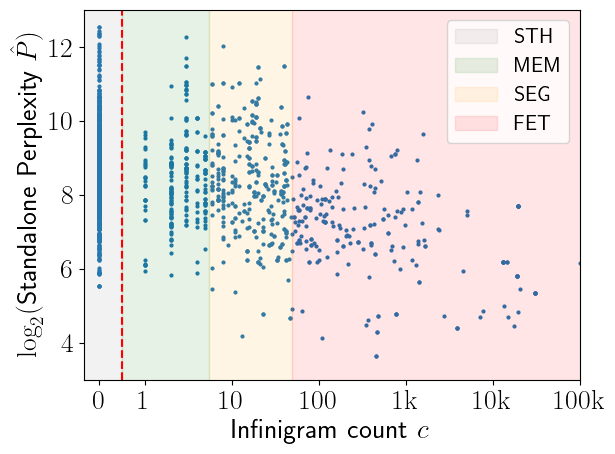

{'Synthetic coherence': 0.519496100779844,
 'Segmental replication': 0.23035392921415718,
 'Frequently encountered text': 0.13017396520695862,
 'Memorization': 0.11997600479904019}

In [173]:
# Filter the DataFrame for the "cyber" dataset

dataset = 'Cryptography'
dataset_df = df[df['dataset'] == dataset]

# Create a scatter plot
fig = plt.scatter(dataset_df['infinigram_count_adj'], dataset_df['perplexity'], s=4)
plt.axvline(x=.55, color='r', linestyle='--')

# Color region where count > 1000
plt.fill_betweenx([0, 15], 0.1, 0.55, color='gray', alpha=0.1, label='STH')
plt.fill_betweenx([0, 15], 0.55, 5.5, color='green', alpha=0.1, label='MEM')
plt.fill_betweenx([0, 15], 5.5, 50, color='orange', alpha=0.1, label='SEG')
plt.fill_betweenx([0, 15], 50, 10000000000, color='red', alpha=0.1, label='FET')

plt.legend(fontsize=15)

# Update x-axis ticks

plt.xlabel('Infinigram count $c$')
plt.ylabel(r'$\log_2($Standalone Perplexity $\hat{P})$')

plt.xlim(0.2, 1e5)
plt.ylim(3, 13)

plt.xscale('log')
plt.xticks([0.3, 1, 10, 100, 1000, 10000, 100000], ['$0$', '$1$', '$10$', '$100$', r'$1\textrm{k}$', r'$10\textrm{k}$', r'$100\textrm{k}$'])

plt.savefig(f'{dataset}_scatter.png', dpi=300, bbox_inches='tight')

plt.show()

# Calculate the counts for each category
region_counts = dataset_df['category'].value_counts(normalize=True).to_dict()

# Display the counts
region_counts

In [157]:
result = df.groupby('dataset').agg(
    avg_perplexity=('perplexity', 'mean'),
    total_low_perplexity_regions=('perplexity', 'count'),
    non_zero_counts=('infinigram_count', lambda x: (x > 0).sum()),
    in_prompt_ratio=('in_prompt', lambda x: f"{(100 * x.sum() / len(x)):.2g}\%")
).reset_index()  # Reset index to make 'dataset' a column
n_windows_stats = {k: {'avg': np.mean(v), 'std': np.std(v)} for k, v in n_windows_per_dataset.items()}

# Add n_windows_avg and n_windows_std columns to the result DataFrame
result['n_windows_avg'] = result['dataset'].map(lambda x: n_windows_stats.get(x, {}).get('avg', np.nan))
result['n_windows_std'] = result['dataset'].map(lambda x: n_windows_stats.get(x, {}).get('std', np.nan))

# Calculate percentage of non-zero counts
result['non_zero_percent'] = (result['non_zero_counts'] / result['total_low_perplexity_regions'] * 100).map('{:.2g}\\%'.format)

# Reorder columns
result = result[['dataset', 'total_low_perplexity_regions', 'non_zero_counts', 'non_zero_percent', 'in_prompt_ratio', 'n_windows_avg', 'n_windows_std']]

# Add a row for all datasets combined
all_datasets_row = {
    'dataset': 'Total',
    'total_low_perplexity_regions': result['total_low_perplexity_regions'].sum(),
    'non_zero_counts': result['non_zero_counts'].sum(),
    'non_zero_percent': f"{(result['non_zero_counts'].sum() / result['total_low_perplexity_regions'].sum() * 100):.2g}\\%",
    'in_prompt_ratio': f"{(result['in_prompt_ratio'].str.rstrip('\\%').astype(float).mean()):.2g}\\%",
    'n_windows_avg': result['n_windows_avg'].mean(),
    'n_windows_std': result['n_windows_std'].mean()
}

# Append the row to the result DataFrame
result = pd.concat([result, pd.DataFrame([all_datasets_row])], ignore_index=True)

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{lrrllrr}
\toprule
dataset & total_low_perplexity_regions & non_zero_counts & non_zero_percent & in_prompt_ratio & n_windows_avg & n_windows_std \\
\midrule
Cryptography & 1667 & 801 & 48\% & 75\% & 2.4 & 3.8 \\
Drugs & 1785 & 593 & 33\% & 64\% & 2.3 & 4.2 \\
Genetics & 1826 & 793 & 43\% & 73\% & 2.3 & 4.3 \\
Nuclear physics & 1343 & 470 & 35\% & 70\% & 2.1 & 3.5 \\
Total & 6621 & 2657 & 40\% & 70\% & 2.3 & 3.9 \\
\bottomrule
\end{tabular}



<>:5: SyntaxWarning:

invalid escape sequence '\%'

<>:5: SyntaxWarning:

invalid escape sequence '\%'

/tmp/ipykernel_11598/4150784391.py:5: SyntaxWarning:

invalid escape sequence '\%'



In [158]:
result = df.groupby(['category', 'dataset']).agg(
    total_low_perplexity_regions=('perplexity', 'count')).reset_index('category')

# Reset index to make dataset a column
result = result.reset_index()
result = result.pivot(index='dataset', columns='category', values='total_low_perplexity_regions')
result.columns.name = None
result = result.div(result.sum(axis=1), axis=0) * 100
result = result[['Synthetic coherence','Memorization','Segmental replication','Frequently encountered text',]].map('{:.2g}\\%'.format)

# Set float format to 2 significant digits
print(result.to_latex(index=True, float_format="%.2g"))

\begin{tabular}{lllll}
\toprule
 & Synthetic coherence & Memorization & Segmental replication & Frequently encountered text \\
dataset &  &  &  &  \\
\midrule
Cryptography & 52\% & 12\% & 23\% & 13\% \\
Drugs & 67\% & 6.6\% & 9.1\% & 18\% \\
Genetics & 57\% & 15\% & 16\% & 12\% \\
Nuclear physics & 65\% & 15\% & 15\% & 5.1\% \\
\bottomrule
\end{tabular}



In [165]:
result = df_temperature.groupby(['category', 'temperature']).agg(
    total_low_perplexity_regions=('perplexity', 'count')).reset_index('category')

# Reset index to make dataset a column
result = result.reset_index()
result = result.pivot(index='temperature', columns='category', values='total_low_perplexity_regions')
result.columns.name = None
result = result.div(result.sum(axis=1), axis=0) * 100
result.reset_index(inplace=True)

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{rrrrr}
\toprule
temperature & Frequently encountered text & Memorization & Segmental replication & Synthetic coherence \\
\midrule
0.2 & 14 & 16 & 18 & 52 \\
0.3 & 13 & 12 & 17 & 57 \\
0.4 & 12 & 15 & 18 & 55 \\
0.5 & 14 & 15 & 17 & 54 \\
0.6 & 13 & 15 & 19 & 54 \\
0.7 & 12 & 15 & 16 & 57 \\
\bottomrule
\end{tabular}



In [130]:
df_temperature[df_temperature['temperature'] == 0.7]['in_prompt'].mean()
df[df['file'] == 'jsons/perplexity_results_crispr_2_with_counts.json']['in_prompt'].mean()

0.6483516483516484

In [174]:
result = df_temperature.groupby('temperature').agg(
    avg_perplexity=('perplexity', 'mean'),
    total_low_perplexity_regions=('perplexity', 'count'),
    non_zero_counts=('infinigram_count', lambda x: (x > 0).sum()),
    in_prompt_ratio=('in_prompt', lambda x: f"{(100 * x.sum() / len(x)):.0f}\%")
)

# Calculate percentage of non-zero counts
result['non_zero_percent'] = (result['non_zero_counts'] / result['total_low_perplexity_regions'] * 100).map('{:.2g}\\%'.format)

# Reorder columns
result= result.reset_index()
result = result[['temperature', 'total_low_perplexity_regions', 'non_zero_counts', 'non_zero_percent', 'in_prompt_ratio', 'avg_perplexity']]

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{rrrllr}
\toprule
temperature & total_low_perplexity_regions & non_zero_counts & non_zero_percent & in_prompt_ratio & avg_perplexity \\
\midrule
0.2 & 8466 & 4099 & 48\% & 89\% & 7.9 \\
0.3 & 6055 & 2600 & 43\% & 88\% & 7.9 \\
0.4 & 4789 & 2155 & 45\% & 81\% & 8 \\
0.5 & 3205 & 1462 & 46\% & 81\% & 8 \\
0.6 & 2294 & 1060 & 46\% & 78\% & 8 \\
0.7 & 1826 & 793 & 43\% & 73\% & 8 \\
\bottomrule
\end{tabular}



<>:5: SyntaxWarning:

invalid escape sequence '\%'

<>:5: SyntaxWarning:

invalid escape sequence '\%'

/tmp/ipykernel_11598/2945807173.py:5: SyntaxWarning:

invalid escape sequence '\%'



In [175]:
import plotly.express as px

# Filter the DataFrame for the "cyber" dataset
cyber_df = df[df['dataset'] == 'Cryptography']

# Create a scatter plot
fig = px.scatter(cyber_df, x='infinigram_count_adj', y='perplexity', color='deduped',
                 title='Scatter Plot of Infinigram Count vs Perplexity for All Dataset',
                 labels={'infinigram_count': 'Infinigram Count', 'perplexity': 'Perplexity'},
                 hover_data=['text'])

fig.update_xaxes(type='log')

fig.update_layout({'width': 1200, 'height': 800})

# Show the plot
fig.show()

defaultdict(list,
            {'jsons/perplexity_results_drugs_nd_with_counts.json': [1,
              1,
              1,
              1,
              1,
              1,
              2,
              3,
              2,
              4,
              1,
              2,
              9,
              2,
              2,
              2,
              1,
              1,
              1,
              2,
              3,
              2,
              1,
              1,
              1,
              4,
              1,
              1,
              2,
              1,
              1,
              1,
              1,
              1,
              1,
              4,
              2,
              5,
              19,
              4,
              1,
              1,
              1,
              2,
              2,
              3,
              2,
              3,
              70,
              1,
              4,
              7,
              1,
              3,
        

In [14]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import glob

# Initialize an empty list to store data from all files
all_data = []
json_file_path = 'jsons/*'  # Replace with actual path

# Function to load JSON files and extract data
for file in glob.glob(json_file_path):
    print(f"Processing: {file}")
    # Extract metadata from filename
    filename_parts = file.split('_')
    dataset = filename_parts[2]  # Assuming dataset is consistently at index 2
    deduped = 'deduped' in file
    
    if 'deduped' in file or 'T0' in file:
        continue
    
    # Load the JSON file
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Extract data from each file while preserving order
    file_data = []
    for el in data:
        # Keep list of items in each element to preserve original order
        element_items = []
        for item in el['low_perplexity_windows']:
            # Create a dictionary for each data point
            data_point = {
                'dataset': dataset,
                'deduped': deduped,
                'infinigram_count': item['infinigram_count'],
                'perplexity': item['window_avg_perplexity'],
                'text': item['window_text'],
                'tokens': item.get('infinigram_tokens', [])
            }
            element_items.append(data_point)
        
        # Add contiguity information
        for i in range(len(element_items) - 1):
            # We'll mark items as contiguous in the next step
            # Also store the index of the next item for easy reference
            element_items[i]['next_index'] = i + 1
        
        # Add the last item without a next_index
        if element_items:
            element_items[-1]['next_index'] = -1
        
        # Add all items from this element to our collection
        file_data.extend(element_items)
    
    # Now determine contiguity between items in this file
    for i in range(len(file_data) - 1):
        # Skip if this is the last item in an element
        if file_data[i]['next_index'] == -1:
            file_data[i]['is_contiguous'] = False
            continue
        
        # Check if there's substring overlap between current and next item
        current_text = file_data[i]['text']
        next_text = file_data[i+1]['text']
        
        # Function to check for substring overlap
        def has_substring_overlap(text1, text2, min_overlap=3):
            # Try different overlap lengths
            for overlap_len in range(min(len(text1), len(text2)), min_overlap-1, -1):
                # Check if end of text1 matches start of text2
                if text1[-overlap_len:] == text2[:overlap_len]:
                    return True
            return False
        
        # Alternatively, check token overlap
        current_tokens = set(file_data[i]['tokens'])
        next_tokens = set(file_data[i+1]['tokens'])
        token_overlap = len(current_tokens.intersection(next_tokens))
        
        # Mark as contiguous if there's significant substring or token overlap
        is_contiguous = has_substring_overlap(current_text, next_text, 3) or token_overlap >= 2
        file_data[i]['is_contiguous'] = is_contiguous
    
    # Add last item as not contiguous
    if file_data:
        file_data[-1]['is_contiguous'] = False
    
    all_data.extend(file_data)
    print(f"Processed {len(file_data)} items from {file}")

df = pd.DataFrame(all_data)

df['infinigram_count_adj'] = df['infinigram_count'].copy()
df.loc[df['infinigram_count_adj'] == 0, 'infinigram_count_adj'] = 0.3

conditions = [
    (df['infinigram_count_adj'] > 100),
    ((df['infinigram_count_adj'] >= 0.1) & (df['infinigram_count_adj'] <= 5) & (df['perplexity'] >= 10)),
    ((df['infinigram_count_adj'] >= 0.55) & (df['infinigram_count_adj'] <= 5) & (df['perplexity'] >= 0) & (df['perplexity'] <= 10)),
    ((df['infinigram_count_adj'] >= 5) & (df['infinigram_count_adj'] <= 100) & (df['perplexity'] >= 0)),
    ((df['infinigram_count_adj'] >= 0.1) & (df['infinigram_count_adj'] <= 0.55) & (df['perplexity'] >= 0) & (df['perplexity'] <= 10))
]

categories = [
    "Frequently encountered text",
    "Degeneration",
    "Memorization",
    "Segmental replication",
    "Synthetic coherence"
]

# Create a pandas DataFrame from the collected data
df['category'] = np.select(conditions, categories, default='Other')

# Display information about the combined dataset
print("\nCombined Dataset Summary:")
print(f"Total entries: {len(df)}")
print(f"Unique datasets: {df['dataset'].unique()}")


Processing: jsons/perplexity_results_crispr_T04_with_counts.json
Processing: jsons/perplexity_results_cyber_with_counts.json
Processed 859 items from jsons/perplexity_results_cyber_with_counts.json
Processing: jsons/perplexity_results_crispr_2_with_counts.json
Processed 1365 items from jsons/perplexity_results_crispr_2_with_counts.json
Processing: jsons/perplexity_results_nuclear_with_counts.json
Processed 1343 items from jsons/perplexity_results_nuclear_with_counts.json
Processing: jsons/perplexity_results_crispr_T03_with_counts.json
Processing: jsons/perplexity_results_drugs_with_counts.json
Processed 1785 items from jsons/perplexity_results_drugs_with_counts.json
Processing: jsons/perplexity_results_crispr_T06_with_counts.json
Processing: jsons/perplexity_results_cyber_2_with_counts.json
Processed 158 items from jsons/perplexity_results_cyber_2_with_counts.json
Processing: jsons/perplexity_results_crispr_deduped_with_counts.json
Processing: jsons/perplexity_results_crispr_T02_with_c

/tmp/ipykernel_61564/3122408488.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['infinigram_count_adj'] == 0, 'infinigram_count_adj'] = 0.3


In [9]:
print(df.head())

  dataset  deduped  infinigram_count  perplexity  \
0   cyber    False               160    7.682092   
1   cyber    False         121772831    7.227530   
2   cyber    False                 8    7.939659   
3   cyber    False                 6    8.497604   
4   cyber    False                14    7.542032   

                                           text  \
0  , integrity, and availability of information   
1                                      ρυπτός k   
2                      ryptos, meaning "hidden,   
3           be used to ensure that messages are   
4         used to ensure that messages are only   

                                              tokens  next_index  \
0  [▁integrity, ,, ▁and, ▁avail, ability, ▁of, ▁i...          -1   
1                                               [▁k]           1   
2                          [▁meaning, ▁", hidden, ,]          -1   
3      [▁used, ▁to, ▁ensure, ▁that, ▁messages, ▁are]           1   
4      [▁to, ▁ensure, ▁that, ▁messages, 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x734e3742e2a0>>
Traceback (most recent call last):
  File "/home/pilgrim/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


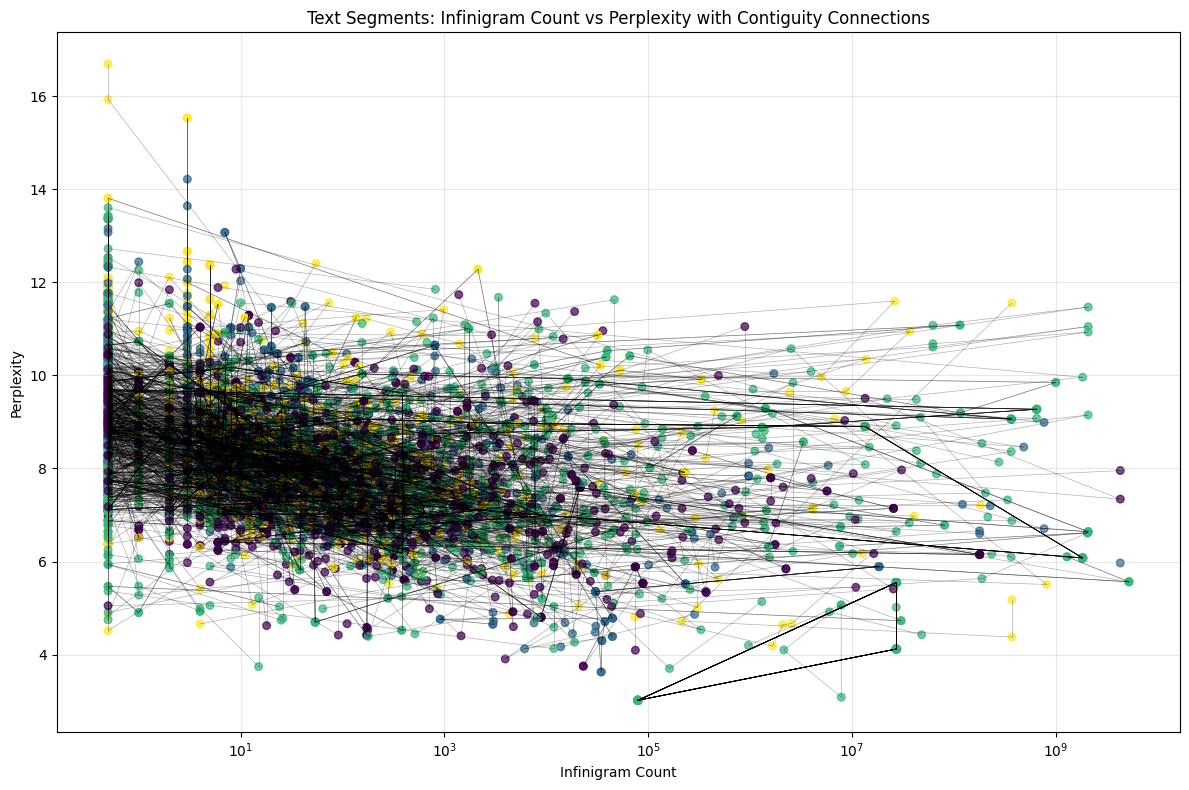

In [ ]:
df_interest = df[df['dataset'] == 'math']
df_interest = df
# change count from 0 to 0.5 for log scale
df_interest['infinigram_count'] = df_interest['infinigram_count'].replace(0, 0.5)

df_interest.reset_index(drop=True, inplace=True)

# Create a scatter plot with connections between contiguous items
plt.figure(figsize=(12, 8))


# Plot all points
scatter = plt.scatter(
    df_interest['infinigram_count'], 
    df_interest['perplexity'],
    alpha=0.7, 
    c=df_interest['dataset'].astype('category').cat.codes,  # Color by dataset
    cmap='viridis',
    s=30  # Point size
)

# Add connections between contiguous segments
for i, row in df_interest.iterrows():
    if row['is_contiguous'] and i < len(df_interest) - 1:
        # Draw a line between this point and the next
        plt.plot(
            [row['infinigram_count'], df_interest.iloc[i+1]['infinigram_count']], 
            [row['perplexity'], df_interest.iloc[i+1]['perplexity']], 
            'k-',  # Black line
            alpha=0.3,  # Make it somewhat transparent
            linewidth=0.5  # Thin line
        )

# Set plot labels and title
plt.xlabel('Infinigram Count')
plt.ylabel('Perplexity')
plt.title('Text Segments: Infinigram Count vs Perplexity with Contiguity Connections')

# Add a grid for better readability
plt.grid(True, alpha=0.3)

# Use logarithmic scale for x-axis since infinigram_count varies widely
plt.xscale('log')

# Show the plot
plt.tight_layout()
plt.savefig('contiguous_segments_plot.png', dpi=300)
plt.show()

# Optional: Create a more detailed visualization focusing on contiguous segments
# Group by dataset and visualize each separately
for dataset_name, group in df_interest.groupby('dataset'):
    plt.figure(figsize=(10, 6))
    
    # Plot all points in this dataset
    plt.scatter(
        group['infinigram_count'], 
        group['perplexity'],
        alpha=0.7,
        label=dataset_name,
        s=30
    )
    plt.xscale('log')
    
    # Add connections between contiguous segments
    connections_count = 0
    for i, row in group.iterrows():
        if row['is_contiguous'] and i < len(df_interest) - 1 and i+1 in group.index:
            # Draw a line between this point and the next
            # if abs(np.log(row['infinigram_count']) - np.log(df_interest.loc[i+1, 'infinigram_count'])) > 0.3:
                # continue
            plt.plot(
                [row['infinigram_count'], df_interest.loc[i+1, 'infinigram_count']], 
                [row['perplexity'], df_interest.loc[i+1, 'perplexity']], 
                'k-',
                alpha=0.4,
                linewidth=0.7
            )
            connections_count += 1
    
    # Set plot labels and title
    plt.xlabel('Infinigram Count')
    plt.ylabel('Perplexity')
    plt.title(f'Dataset: {dataset_name} - {connections_count} Contiguous Connections')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'contiguous_segments_{dataset_name}.png', dpi=300)
    plt.show()

In [120]:
df_interest[df_interest['is_contiguous'] == True]

,dataset,deduped,infinigram_count,perplexity,text,tokens,next_index,is_contiguous
3,cyber,False,6.0,8.497604,be used to ensure that messages are,"[▁used, ▁to, ▁ensure, ▁that, ▁messages, ▁are]",1,True
7,cyber,False,34.0,8.119696,receiver uses the same key to dec,"[▁uses, ▁the, ▁same, ▁key, ▁to, ▁dec]",1,True
8,cyber,False,122.0,6.313290,uses the same key to decrypt,"[▁the, ▁same, ▁key, ▁to, ▁dec, rypt]",2,True
9,cyber,False,47.0,8.887592,the same key to decrypt the,"[▁same, ▁key, ▁to, ▁dec, rypt, ▁the]",3,True
10,cyber,False,623.0,8.572116,same key to decrypt the message,"[▁key, ▁to, ▁dec, rypt, ▁the, ▁message]",4,True
...,...,...,...,...,...,...,...,...
6888,crispr,False,27113.0,5.575808,wide association studies (GWAS),"[▁association, ▁studies, ▁(, G, W, AS, )]",1,True
6890,crispr,False,5.0,10.285876,the causal gene or genes.\n,"[▁caus, al, ▁gene, ▁or, ▁gen, es, .]",3,True
6891,crispr,False,501.0,10.134613,causal gene or genes.\n\n,"[▁gene, ▁or, ▁gen, es, .]",4,True
6893,crispr,False,3435.0,5.592325,fruit fly Drosophila melanogaster,"[▁fly, ▁D, ros, oph, ila, ▁mel, an, og, aster]",1,True


[[  0. 271.   2. 198.  43.]
 [  0. 894.  22. 784. 107.]
 [  0. 341.   2. 262.  49.]
 [  0. 676.   6. 562.  84.]
 [  0. 580.   5. 476.  83.]]


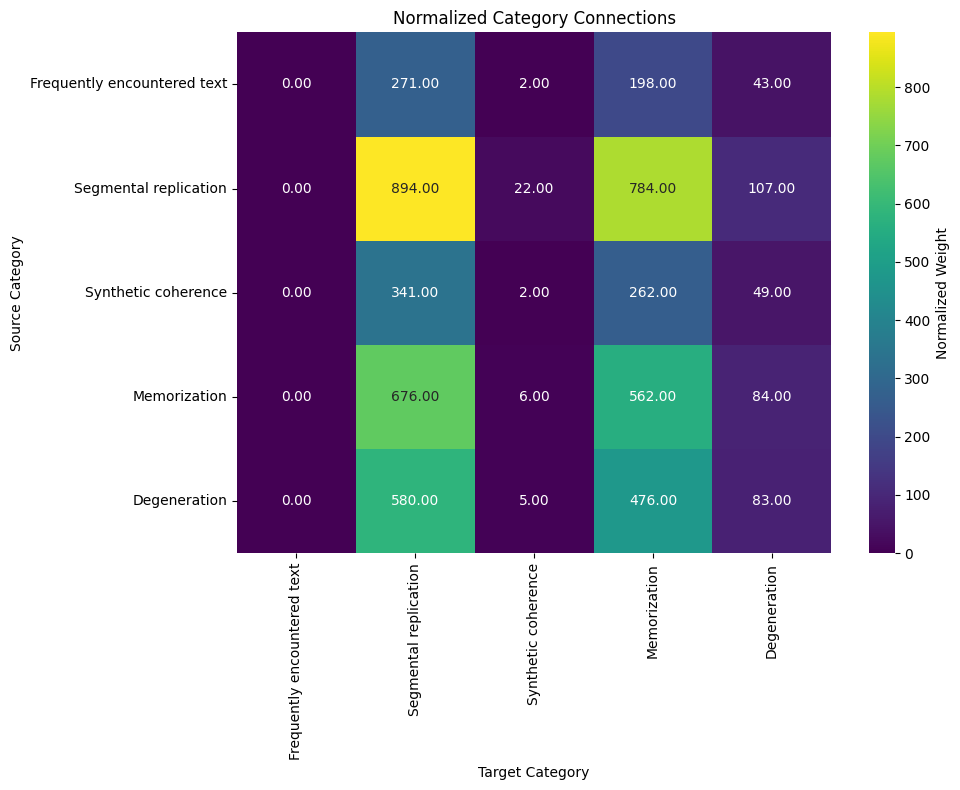

In [26]:
import seaborn as sns

unique_categories = df['category'].unique()

# Initialize variables
num_categories = len(unique_categories)
matrix = np.zeros((num_categories, num_categories))

for i, row in df.iterrows():
    next_idx = row['next_index']
    if next_idx != -1 and next_idx < len(df):
        source_cat = row['category']
        target_cat = df.iloc[next_idx]['category']
        source_idx = category_to_index[source_cat]
        target_idx = category_to_index[target_cat]
        matrix[source_idx, target_idx] += 1 # row['infinigram_count_adj']

matrix_df = pd.DataFrame(matrix, index=unique_categories, columns=unique_categories)

print(matrix)

# Normalize the matrix per row
normalized_matrix = matrix

# Convert the normalized matrix to a DataFrame
normalized_matrix_df = pd.DataFrame(normalized_matrix, index=unique_categories, columns=unique_categories)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix_df, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Normalized Weight'})
plt.title("Normalized Category Connections")
plt.xlabel("Target Category")
plt.ylabel("Source Category")
plt.tight_layout()
plt.show()

/tmp/ipykernel_15912/3073161426.py:78: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



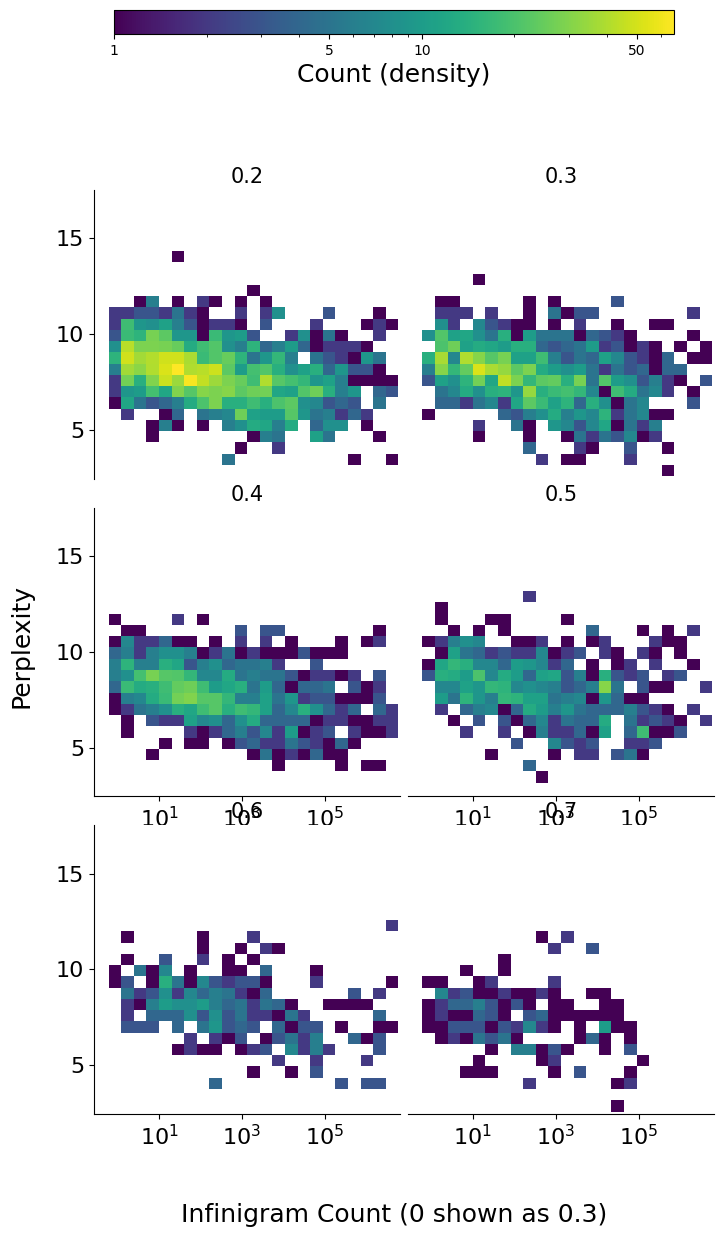

In [31]:

# Get unique datasets
datasets = df_temperature.groupby('temperature')
n_datasets = len(datasets)

# Determine global min and max for consistent scales
perp_min = df['perplexity'].min()
perp_max = df['perplexity'].max()
inf_min = df['infinigram_count_adj'].min()
inf_max = df['infinigram_count_adj'].max()

fig = plt.figure(figsize=(8, 12))
gs = GridSpec(3, 2, figure=fig, wspace=0.025, hspace=0.1)

# Define consistent bins for histograms
x_bins = np.logspace(np.log10(inf_min), np.log10(max(inf_max, 1000)), 25)
y_bins = np.linspace(perp_min, perp_max, 25)

# Define consistent colormap and normalization for all plots
cmap = plt.cm.viridis
norm = colors.LogNorm()  # Use log normalization for the colormap

# Create all plots
for i, (dataset_name, dataset_df) in enumerate(datasets):
    row, col = i // 2, i % 2
    ax = fig.add_subplot(gs[row, col])
    
    # ax.set_facecolor(cmap(0))
    
    # Create 2D histogram
    h, xedges, yedges, img = ax.hist2d(
        dataset_df['infinigram_count'],
        dataset_df['perplexity'],
        bins=[x_bins, y_bins],
        cmap=cmap,
        norm=norm,
        cmin=.1
    )
    
    # Configure axis scales
    ax.set_xscale('log')
    
    # Set consistent axis limits
    ax.set_xlim(inf_min * 0.9, inf_max * 1.1)
    ax.set_ylim(perp_min * 0.95, perp_max * 1.05)
    
    # Make only bottom x-axis and left y-axis visible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if row == 0:
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_ticks([])
    if col == 1:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks([])
        
    # Set axis label font sizes
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    # Add subtle title with dataset name
    ax.set_title(dataset_name, fontsize=15, color='black', pad=5)

# Add a colorbar at the top that applies to all subplots
cbar_ax = fig.add_axes([0.15, 1.01, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Count (density)', fontsize=18)
cbar.set_ticks([1, 5, 10, 50])
cbar.set_ticklabels(['1', '5', '10', '50'])

# Add centered x-axis label for both columns
fig.text(0.5, 0.02, 'Infinigram Count (0 shown as 0.3)', ha='center', fontsize=18)

# Add centered y-axis label for both rows
fig.text(0.02, 0.5, 'Perplexity', va='center', rotation='vertical', fontsize=18)

# Adjust layout for better spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.9])  # [left, bottom, right, top]

plt.savefig('../images/scatter_subplots.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_15912/3405773284.py:84: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



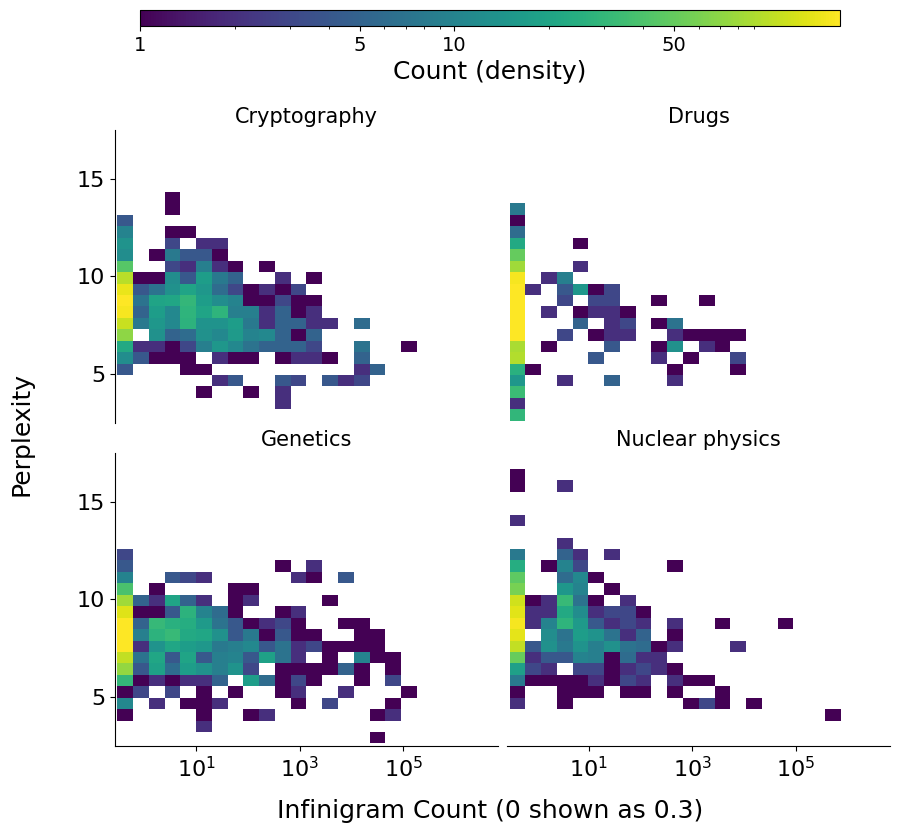

In [47]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

# Get unique datasets
datasets = df.groupby('dataset')
n_datasets = len(datasets)

# Determine global min and max for consistent scales
perp_min = df['perplexity'].min()
perp_max = df['perplexity'].max()
inf_min = df['infinigram_count_adj'].min()
inf_max = df['infinigram_count_adj'].max()

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, figure=fig, wspace=0.025, hspace=0.1)

# Define consistent bins for histograms
x_bins = np.logspace(np.log10(inf_min), np.log10(max(inf_max, 1000)), 25)
y_bins = np.linspace(perp_min, perp_max, 25)

# Define consistent colormap and normalization for all plots
cmap = plt.cm.viridis
norm = colors.LogNorm()  # Use log normalization for the colormap

# Create all plots
for i, (dataset_name, dataset_df) in enumerate(datasets):
    row, col = i // 2, i % 2
    ax = fig.add_subplot(gs[row, col])
    
    # ax.set_facecolor(cmap(0))
    
    # Create 2D histogram
    h, xedges, yedges, img = ax.hist2d(
        dataset_df['infinigram_count_adj'],
        dataset_df['perplexity'],
        bins=[x_bins, y_bins],
        cmap=cmap,
        norm=norm,
        cmin=.1
    )
    
    # Configure axis scales
    ax.set_xscale('log')
    
    # Set consistent axis limits
    ax.set_xlim(inf_min * 0.9, inf_max * 1.1)
    ax.set_ylim(perp_min * 0.95, perp_max * 1.05)
    
    # Make only bottom x-axis and left y-axis visible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if row == 0:
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_ticks([])
    if col == 1:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks([])
        
    # Set axis label font sizes
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    # Add subtle title with dataset name
    ax.set_title(dataset_name, fontsize=15, color='black', pad=5)

# Add a colorbar at the top that applies to all subplots
cbar_ax = fig.add_axes([0.15, 1.01, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Count (density)', fontsize=18)
cbar.set_ticks([1, 5, 10, 50])
cbar.set_ticklabels(['1', '5', '10', '50'])

# Add centered x-axis label for both columns
fig.text(0.5, 0.02, 'Infinigram Count (0 shown as 0.3)', ha='center', fontsize=18)

# Add centered y-axis label for both rows
fig.text(0.02, 0.5, 'Perplexity', va='center', rotation='vertical', fontsize=18)

# Adjust layout for better spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.9])  # [left, bottom, right, top]

plt.savefig('../images/scatter_subplots.png', dpi=300, bbox_inches='tight')
plt.show()